In [ ]:
# The data:
# From CDAWeb; Wind, OMNI etc.
# Can download in bulk with an ftp client (filezilla)


# Improvements:
# -robustness of the scale calculation methods
# -more data
# -dealing with missing data
# -?

Import libraries needed

In [23]:
import pandas as pd
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import cdflib

import statsmodels.api as sm

from scipy.optimize import curve_fit

Define helper functions

In [5]:
def read_cdf(cdf_file_path:str) -> cdflib.cdfread.CDF:
  """
  Read a .cdf file as a cdf file object
  """
  try:
    cdf_file_object = cdflib.CDF(cdf_file_path)
  except Exception:
    raise Exception('Exception while reading file')
  return cdf_file_object

def convert_cdf_to_dataframe(cdf_file_object:cdflib.cdfread.CDF, varlist=None) -> pd.DataFrame:
  """
  Convert a cdf file object to a Pandas DataFrame.
  args:
    varlist: list of strings. Specify the variables to include in the resulting DataFrame as they appear in the .cdf file.
             Multi-dimensional attributes are split into multiple columns with the names attribute_x
  """
  # if varlist == None:
  #   varlist = cdf_file_object.cdf_info()['rVariables'] + cdf_file_object.cdf_info()['zVariables']
  variables_to_read = varlist.copy()
  # for var_name in varlist:
  #   if var_name not in cdf_file_object.cdf_info()['rVariables'] + cdf_file_object.cdf_info()['zVariables']:
  #     print(f'variable name "{var_name}" not in cdf file; skipping it')
  #     variables_to_read.remove(var_name)
  result_dict = {}
  for var_name in variables_to_read:
    variable_values = cdf_file_object.varget(var_name)
    if len(variable_values.shape) == 1: # single attribute
      result_dict.update({var_name: variable_values})
    else: # multi-dimensional attribute
      expanded_dict = {f'{var_name}_{dim_index}': variable_values[:,dim_index] for dim_index in range(variable_values.shape[1])}
      result_dict.update(expanded_dict)
  return pd.DataFrame(result_dict)

def replace_fill_values(dataframe:pd.DataFrame) -> None:
  """
  Replace dataframe fill values with numpy NaN. Fill values are documented in https://omniweb.gsfc.nasa.gov/html/omni_min_data.html.
  Changes are done in place.
  """
  dataframe.replace({9.9: np.nan, 999: np.nan, 999.99: np.nan, 999999: np.nan,
                     99.99: np.nan, 9999.99: np.nan, 9999999.: np.nan, 99999.99: np.nan,
                     99999.9: np.nan, 99999: np.nan}, inplace=True)
  return

def format_epochs(dataframe:pd.DataFrame) -> pd.DataFrame:
  """
  Convert Epoch attribute into a DateTime object. Epoch column must exist.
  """
  assert type(dataframe) == pd.core.frame.DataFrame, 'Input is not of type DataFrame'
  assert 'Epoch' in dataframe.columns or 'EPOCH' in dataframe.columns, 'Epoch column does not exist'
  result_dataframe = dataframe.copy()
  result_dataframe['Epoch'] = result_dataframe['Epoch'].apply(lambda x: cdflib.epochs.CDFepoch.to_datetime(x, to_np=True)[0])
  result_dataframe.rename({'Epoch': 'Timestamp'}, axis='columns', inplace=True)
  return result_dataframe

def resample_time_series(dataframe:pd.DataFrame, cadence: str='5T', agg_types:dict = None) -> pd.DataFrame:
  """
  Resample time series data to a regular cadence in order to merge data from different sources.
  """
  if not cadence:
    return dataframe.set_index('Timestamp')
  assert type(dataframe) == pd.core.frame.DataFrame, 'Input is not of type DataFrame'
  assert 'Timestamp' in dataframe.columns, 'Timestamp column does not exist'
  if not agg_types:
    return dataframe.resample(cadence, on='Timestamp').mean()
  return dataframe.resample(cadence, on='Timestamp').agg(agg_types)

def join_dataframes_on_timestamp(dataframe_1:pd.DataFrame, dataframe_2:pd.DataFrame) -> pd.DataFrame:
  """
  Join dataframes on the Timestamp attribute. Dataframes should be (re)sampled on the same cadence.
  """
  assert type(dataframe_1.index) == pd.core.indexes.datetimes.DatetimeIndex, 'dataframe_1 does not have a Datetime index'
  assert type(dataframe_2.index) == pd.core.indexes.datetimes.DatetimeIndex, 'dataframe_2 does not have a Datetime index'
  joined_df = pd.merge(dataframe_1, dataframe_2, how='left', on='Timestamp')
  return joined_df

def mask_and_interpolate_outliers(dataframe: pd.DataFrame, threshold_dict: dict) -> pd.DataFrame:
  """
  Mask values outside of the specified thresholds with numpy NaNs. Interpolate NaNs
  inputs:
    threshold_dict: dict. Pairs of column names and thresholds to identify outliers.
  """
  # if more than 40% of values in any column are missing, skip data period
  if (dataframe.isna().sum()/dataframe.shape[0] >= 0.4).any():
    return None
  if not threshold_dict:
    return dataframe.copy().interpolate().ffill().bfill()
  result_dataframe = dataframe.copy()
  for column_name, thresholds in threshold_dict.items():
    result_dataframe[column_name] = result_dataframe[column_name].mask((result_dataframe[column_name] <= thresholds[0]) | (result_dataframe[column_name] >= thresholds[-1])).interpolate().ffill().bfill()
  return result_dataframe

def estimate_second_derivative(autocorrelation_function_array: np.ndarray, limit: int=10, steps: int=50, only_origin: bool=False) -> np.ndarray:
  """
  Estimate the second derivative of the autocorrelation function near the origin.
  inputs:
    limit: int. Defines the neighborhood around the origin to fit splines on. Recommended 10
    steps: int. Defines the resolution of the second derivative function.
           Mainly used for plotting. Recommended about 5X the limit.
    only_origin: bool. Ignore plotting and only output value at origin.
  """
  y_splines_fit = UnivariateSpline(range(len(autocorrelation_function_array)),
                               autocorrelation_function_array,
                               s=0,
                               k=3)
  if only_origin:
    return y_splines_fit.derivative(n=2)(0)
  x_range = np.linspace(0, limit, steps)
  second_derivative = y_splines_fit.derivative(n=2)(x_range)
  return second_derivative

def pipeline(file_path, varlist, cadence='5T', thresholds={}):
    try:
        df = convert_cdf_to_dataframe(read_cdf(file_path), varlist=varlist)
        replace_fill_values(df)
        df = format_epochs(df)
        # df.set_index('Timestamp', inplace=True)
        df = mask_and_interpolate_outliers(df, thresholds)
        if df is None or df.shape[0] == 0:
          print('dataframe had too many missing values')
          return None
        if cadence not in [0, '0S', None]:
          df = resample_time_series(df, cadence=cadence).interpolate().ffill().bfill()
        # df.set_index('Timestamp', inplace=True)
        return df.sort_index()
    except Exception as e:
        print(e)
        return pd.DataFrame()

def print_cdf_info(file_path: str) -> None:
  """
  Print the cdf info of the specified file
  """
  pprint(read_cdf(file_path).cdf_info())

def compute_autocorrelation_function(dataframe: pd.DataFrame, number_of_lags: int) -> np.ndarray:
  """
  Compute autocorrelation function of time series data with specified number of lags.
  """
  # autocorrelation = sm.tsa.acf(dataframe[column_name] - np.mean(dataframe[column_name]), fft=False, nlags=number_of_lags)
  autocorrelation = sm.tsa.acf(dataframe['BGSE_0'], fft=False, nlags=number_of_lags) + sm.tsa.acf(dataframe['BGSE_1'], fft=False, nlags=number_of_lags) + sm.tsa.acf(dataframe['BGSE_2'], fft=False, nlags=number_of_lags)
  autocorrelation /= 3
  return autocorrelation

def exp_fit(r, lambda_c):
  return np.exp(-1*r/lambda_c)

def para_fit(x, a):
  return a*x**2 + 1

def convert_cadence_to_string(seconds) -> str:
  return f'{seconds}S'

def compute_taylor_correlation_time_scales(dataframe, ind_1, ind_2, sample_interval, num_lags=100, show=False):
  if show:
    print(f'{ind_1} to {ind_2}')
  ts = dataframe[ind_1:ind_2]
  ac = compute_autocorrelation_function(ts, num_lags)
  ac_x = np.array(range(len(ac)))

  ac_x = ac_x*sample_interval
  num_seconds_for_lambda_t_fit = 2
  num_lags_for_lambda_t_fit = int(num_seconds_for_lambda_t_fit/sample_interval)
  print(num_lags_for_lambda_t_fit)
  num_seconds_for_lambda_c_fit = 20
  num_lags_for_lambda_c_fit = int(num_seconds_for_lambda_c_fit/sample_interval)
  c_opt, c_cov = curve_fit(exp_fit, ac_x[:num_lags_for_lambda_c_fit], ac[:num_lags_for_lambda_c_fit], 1000)
  t_opt, t_cov = curve_fit(para_fit, ac_x[:num_lags_for_lambda_t_fit], ac[:num_lags_for_lambda_t_fit], 100)
  # c_opt, c_cov = curve_fit(exp_fit, ac_x[:len(ts)//20], ac[:len(ts)//20], 100)
  # t_opt, t_cov = curve_fit(para_fit, ac_x[:len(ts)//100], ac[:len(ts)//100], 100)
  lambda_c = c_opt[0]
  lambda_t = (-1*t_opt[0])**-.5
  if show:
    ax = plt.gca()
    ax.set_ylim(-.2, 1.2)
    plt.plot(ac_x, ac)
    plt.plot(np.array(range(int(1.1*lambda_c))), exp_fit(np.array(range(int(1.1*lambda_c))), *c_opt), 'r-')
    plt.plot(np.array(range(int(1.1*lambda_t))), para_fit(np.array(range(int(1.1*lambda_t))), *t_opt), 'g-')
    box_color = 'grey' if lambda_c > lambda_t else 'red'
    ax.text(ac_x[-1]*(12/10), .9, f'lambda_c: {round(lambda_c, 1)} [sec]\nlambda_t: {round(lambda_t, 1)} [sec]',style='italic', fontsize=10,
          bbox={'facecolor': box_color, 'alpha': 0.5, 'pad': 10})
    plt.show()

    print(f'correlation (time) scale: {round(lambda_c, 3)} [sec]')
    print(f'transverse taylor (time) scale: {round(lambda_t, 3)} [sec]')
  return ind_1, round(lambda_c, 5), round(lambda_t, 5), sample_interval

def estimate_correlation_scale(autocorrelation_x: np.ndarray, autocorrelation_y: np.ndarray):
  """
  autocorrelation_x assumed already in time scale
  """
  for i, j in zip(autocorrelation_y, autocorrelation_x):
    if i <= np.exp(-1):
      # print(i, j)
      idx_2 = np.where(autocorrelation_x==j)[0]
      idx_1 = idx_2 - 1
      x2 = autocorrelation_x[idx_2]
      x1 = autocorrelation_x[idx_1]
      y1 = autocorrelation_y[idx_1]
      y2 = autocorrelation_y[idx_2]
      x_opt = x1 + ((y1 - np.exp(-1))/(y1-y2))*(x2-x1)
      # print(autocorrelation_x[idx_1], autocorrelation_y[idx_1])
      # print(autocorrelation_x[idx_2], autocorrelation_y[idx_2])
      # print('e:', np.exp(-1))
      # print(x_opt)
      # print(x_opt)
      try:
        return round(x_opt[0], 3)
      except Exception:
        return 0
  # none found
  return -1

def compute_taylor_time_scale(dataframe, ind_1, ind_2, sample_interval, num_lags=100, show=False):
    try:
      if show:
        print(f'{ind_1} to {ind_2}')
      ts = dataframe[ind_1:ind_2]
      ac = compute_autocorrelation_function(ts, num_lags)
      ac_x = np.array(range(len(ac)))
      ac_x = ac_x*sample_interval
      num_seconds_for_lambda_t_fit = 2
      num_lags_for_lambda_t_fit = int(num_seconds_for_lambda_t_fit/sample_interval)
      # print(num_lags_for_lambda_t_fit)
      t_opt, t_cov = curve_fit(para_fit, ac_x[:num_lags_for_lambda_t_fit], ac[:num_lags_for_lambda_t_fit], 10)
      lambda_t = (-1*t_opt[0])**-.5
      print(ind_1, t_opt, lambda_t)
      if show:
        ax = plt.gca()
        ax.set_ylim(-.2, 1.2)
        plt.plot(ac_x, ac)
        plt.plot(np.array(range(int(1.1*lambda_t))), para_fit(np.array(range(int(1.1*lambda_t))), *t_opt), 'g-')
        box_color = 'grey' if lambda_t < 50 else 'red'
        ax.text(ac_x[-1]*(8/10), .9, f'lambda_t: {round(lambda_t, 1)} [sec]',style='italic', fontsize=10,
              bbox={'facecolor': box_color, 'alpha': 0.5, 'pad': 10})
        plt.show()

        print(f'transverse taylor (time) scale: {round(lambda_t, 3)} [sec]')
        print('')
      return ind_1, round(lambda_t, 5), sample_interval
    except Exception:
        return ind_1, -1, sample_interval

def compute_correlation_time_scale(dataframe, ind_1, ind_2, sample_interval, num_lags=100, show=False):
    try:
        if show:
            print(f'{ind_1} to {ind_2}')
        ts = dataframe[ind_1:ind_2]
        ac = compute_autocorrelation_function(ts, num_lags)
        ac_x = np.array(range(len(ac)))

        ac_x = ac_x*sample_interval
        num_seconds_for_lambda_c_fit = 1000

      # estimate using 1/e trick
        lambda_c_estimate = estimate_correlation_scale(ac_x, ac)


        num_lags_for_lambda_c_fit = int(num_seconds_for_lambda_c_fit/sample_interval)
      # print(num_lags_for_lambda_c_fit)
        c_opt, c_cov = curve_fit(exp_fit, ac_x[:num_lags_for_lambda_c_fit], ac[:num_lags_for_lambda_c_fit], 1000)
        lambda_c = c_opt[0]
        if show:
          ax = plt.gca()
          ax.set_ylim(-.2, 1.2)
          plt.plot(ac_x, ac)
          plt.plot(np.array(range(int(num_seconds_for_lambda_c_fit))), exp_fit(np.array(range(int(num_seconds_for_lambda_c_fit))), *c_opt), 'r-')
          box_color = 'grey' if lambda_c > 50 else 'red'
          ax.text(ac_x[-1]*(5/10), 0.9, f'lambda_c: {round(lambda_c, 1)} [sec]\nestimate: {round(lambda_c_estimate, 1)} [sec]',style='italic', fontsize=10,
                bbox={'facecolor': box_color, 'alpha': 0.5, 'pad': 10})
          plt.show()

          print(f'correlation (time) scale: {round(lambda_c, 3)} [sec]')
        print(f'{ind_1}: {round(lambda_c, 5)}, {round(lambda_c_estimate, 5)}')
        return ind_1, round(lambda_c, 5), round(lambda_c_estimate, 5), sample_interval
    except Exception:
        return ind_1, -1, -1, sample_interval


In [4]:
#project_path = '/content/drive/MyDrive/Victoria/COMP589/summary/'

Demo functions

In [6]:
omni = read_cdf('omni_hro2_1min_20210101_v01.cdf')
type(omni)

cdflib.cdfread.CDF

In [7]:
omni.cdf_info()

{'CDF': WindowsPath('C:/Users/spann/Documents/Research/Kevin_scales/summary/omni_hro2_1min_20210101_v01.cdf'),
 'Version': '3.8.0',
 'Encoding': 1,
 'Majority': 'Row_major',
 'rVariables': [],
 'zVariables': ['Epoch',
  'YR',
  'Day',
  'HR',
  'Minute',
  'IMF',
  'PLS',
  'IMF_PTS',
  'PLS_PTS',
  'percent_interp',
  'Timeshift',
  'RMS_Timeshift',
  'RMS_phase',
  'Time_btwn_obs',
  'F',
  'BX_GSE',
  'BY_GSE',
  'BZ_GSE',
  'BY_GSM',
  'BZ_GSM',
  'RMS_SD_B',
  'RMS_SD_fld_vec',
  'flow_speed',
  'Vx',
  'Vy',
  'Vz',
  'proton_density',
  'T',
  'NaNp_Ratio',
  'Pressure',
  'E',
  'Beta',
  'Mach_num',
  'Mgs_mach_num',
  'x',
  'y',
  'z',
  'BSN_x',
  'BSN_y',
  'BSN_z',
  'AE_INDEX',
  'AL_INDEX',
  'AU_INDEX',
  'SYM_D',
  'SYM_H',
  'ASY_D',
  'ASY_H'],
 'Attributes': [{'Project': 'Global'},
  {'Discipline': 'Global'},
  {'Source_name': 'Global'},
  {'Data_type': 'Global'},
  {'Descriptor': 'Global'},
  {'Data_version': 'Global'},
  {'TITLE': 'Global'},
  {'TEXT': 'Global'},

In [8]:
omni_df = convert_cdf_to_dataframe(omni, varlist=['Epoch', 'F', 'flow_speed', 'T', 'Pressure'])
omni_df.head()

,Epoch,F,flow_speed,T,Pressure
0,6.377668e+13,2.79,360.100006,35575.0,1.16
1,6.377668e+13,2.79,360.100006,35575.0,1.16
2,6.377668e+13,2.80,358.000000,40666.0,1.12
3,6.377668e+13,2.92,358.100006,36450.0,1.24
4,6.377668e+13,2.92,358.100006,34138.0,1.30


In [9]:
omni_df = format_epochs(omni_df)
omni_df

,Timestamp,F,flow_speed,T,Pressure
0,2021-01-01 00:00:00,2.790000,360.100006,35575.0,1.160000
1,2021-01-01 00:01:00,2.790000,360.100006,35575.0,1.160000
2,2021-01-01 00:02:00,2.800000,358.000000,40666.0,1.120000
3,2021-01-01 00:03:00,2.920000,358.100006,36450.0,1.240000
4,2021-01-01 00:04:00,2.920000,358.100006,34138.0,1.300000
...,...,...,...,...,...
44635,2021-01-31 23:55:00,5.120000,332.600006,27448.0,1.880000
44636,2021-01-31 23:56:00,9999.990234,332.600006,27448.0,1.880000
44637,2021-01-31 23:57:00,5.100000,99999.898438,9999999.0,99.989998
44638,2021-01-31 23:58:00,5.150000,333.100006,28752.0,1.910000


<AxesSubplot:>

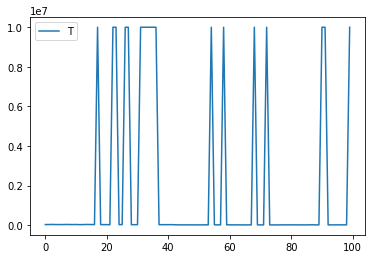

In [10]:
omni_df[['T']][:100].plot()

<AxesSubplot:>

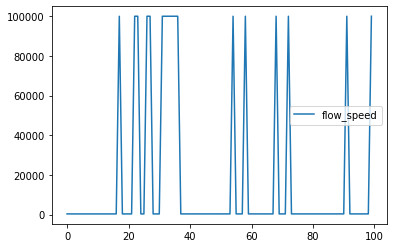

In [11]:
omni_df[['flow_speed']][:100].plot()

In [12]:
omni_df = mask_and_interpolate_outliers(omni_df, threshold_dict={
    'flow_speed': [0, 10000],
    'T': [0, 1000000]
})

<AxesSubplot:>

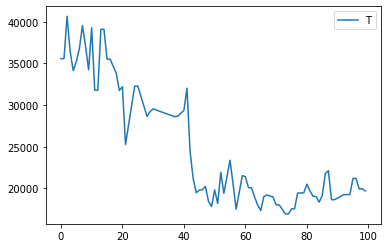

In [13]:
omni_df[['T']][:100].plot()

<AxesSubplot:>

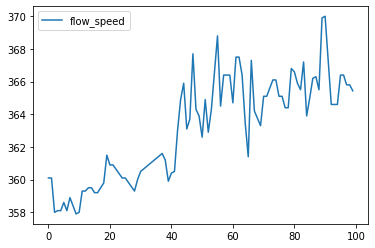

In [14]:
omni_df[['flow_speed']][:100].plot()

In [15]:
resampled = resample_time_series(omni_df, cadence='5T')
resampled

,F,flow_speed,T,Pressure
Timestamp,,,,
2021-01-01 00:00:00,2.844000,358.880005,36480.800781,1.196000
2021-01-01 00:05:00,2.982000,358.380005,36568.800781,1.114000
2021-01-01 00:10:00,3.026000,359.119995,36206.800781,1.174000
2021-01-01 00:15:00,2002.434082,359.839996,34252.000000,20.911999
2021-01-01 00:20:00,2002.378052,360.579987,29452.800781,40.695999
...,...,...,...,...
2021-01-31 23:35:00,4.662000,334.040009,31832.400391,2.036000
2021-01-31 23:40:00,5.022000,332.880005,29445.000000,1.976000
2021-01-31 23:45:00,5.068000,330.739990,28334.000000,1.900000


In [16]:
df1 = pipeline('omni_hro2_1min_20210101_v01.cdf', 
               varlist=['Epoch', 'flow_speed'], 
               cadence='5T', 
               thresholds={
                   'flow_speed': [0, 10000],
                  #  'T': [0, 1000000]
                   }
               )
df1.head()

,flow_speed
Timestamp,
2021-01-01 00:00:00,358.880005
2021-01-01 00:05:00,358.380005
2021-01-01 00:10:00,359.119995
2021-01-01 00:15:00,359.839996
2021-01-01 00:20:00,360.579987


In [17]:
df2 = pipeline('omni_hro2_1min_20210101_v01.cdf', 
               varlist=['Epoch', 'T'], 
               cadence='5T', 
               thresholds={
                   'T': [0, 1000000]
                   }
               )
df2.head()

,T
Timestamp,
2021-01-01 00:00:00,36480.800781
2021-01-01 00:05:00,36568.800781
2021-01-01 00:10:00,36206.800781
2021-01-01 00:15:00,34252.000000
2021-01-01 00:20:00,29452.800781


In [18]:
joined_df = join_dataframes_on_timestamp(df1, df2)
joined_df.head()

,flow_speed,T
Timestamp,,
2021-01-01 00:00:00,358.880005,36480.800781
2021-01-01 00:05:00,358.380005,36568.800781
2021-01-01 00:10:00,359.119995,36206.800781
2021-01-01 00:15:00,359.839996,34252.000000
2021-01-01 00:20:00,360.579987,29452.800781


In [24]:
print_cdf_info('wi_h2_mfi_20220325_v03.cdf')

{'Attributes': [{'Project': 'Global'},
                {'Discipline': 'Global'},
                {'Source_name': 'Global'},
                {'Software_version': 'Global'},
                {'Data_type': 'Global'},
                {'Descriptor': 'Global'},
                {'Data_version': 'Global'},
                {'TITLE': 'Global'},
                {'TEXT': 'Global'},
                {'MODS': 'Global'},
                {'ADID_ref': 'Global'},
                {'Logical_file_id': 'Global'},
                {'Logical_source': 'Global'},
                {'Logical_source_description': 'Global'},
                {'Processing_date': 'Global'},
                {'Level_0_file': 'Global'},
                {'HKlvl_0_file': 'Global'},
                {'Orbit_file': 'Global'},
                {'Attitude_file': 'Global'},
                {'def_FLAGS': 'Global'},
                {'def_SPC_MODE': 'Global'},
                {'def_MAG_MODE': 'Global'},
                {'PI_name': 'Global'},
           

In [48]:
mfi = pipeline('wi_h2_mfi_20220325_v03.cdf', varlist=['Epoch', 'BF1', 'BGSE'],
               thresholds={'BF1': [0, 50],
                           'BGSE_0': [0, 50],
                           'BGSE_1': [0, 50],
                           'BGSE_2': [0, 50]}, 
               cadence=convert_cadence_to_string(0.1))
mfi

,BF1,BGSE_0,BGSE_1,BGSE_2
Timestamp,,,,
2022-03-25 00:00:00.000,4.159470,0.010920,0.446127,0.005310
2022-03-25 00:00:00.100,4.166633,0.010920,0.436836,0.005310
2022-03-25 00:00:00.200,4.157491,0.010920,0.402740,0.005310
2022-03-25 00:00:00.300,4.178423,0.010920,0.410756,0.005310
2022-03-25 00:00:00.400,4.159176,0.010920,0.378947,0.005310
...,...,...,...,...
2022-03-25 23:59:59.500,4.700688,0.006707,0.074823,3.318956
2022-03-25 23:59:59.600,4.694927,0.006707,0.074823,3.312703
2022-03-25 23:59:59.700,4.707192,0.006707,0.074823,3.322201


In [40]:
# Creating smaller version of mfi for running on local computer
mfi = mfi[:100000]

<AxesSubplot:xlabel='Timestamp'>

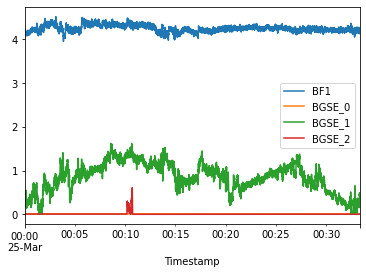

In [41]:
mfi.plot()

In [47]:
num_periods = ((mfi.index[-1] - mfi.index[0]).days*(24*60*60) + (mfi.index[-1] - mfi.index[0]).seconds) // (6 * 60*60)
num_periods

0

In [39]:
# Previously num_lags set to 100000 (this takes a long time on local machine)
corr_scales = pd.DataFrame([compute_correlation_time_scale(mfi, mfi.index[0] + (i*pd.DateOffset(hours=6)), mfi.index[0] + (i+1)*pd.DateOffset(hours=6), 0.1, num_lags=100000, show=True) for i in range(num_periods)], columns=['Timestamp', 'cor_ts', 'cor_ts_est', 'sample_freq'])
corr_scales.set_index('Timestamp', inplace=True)

In [38]:
corr_scales

,cor_ts,cor_ts_est,sample_freq
Timestamp,,,


In [46]:
taylor_scales = pd.DataFrame([compute_taylor_time_scale(mfi, mfi.index[0] + (i*pd.DateOffset(hours=6)), mfi.index[0] + (i+1)*pd.DateOffset(hours=6), 0.1, num_lags=20, show=True) for i in range(num_periods)], columns=['Timestamp', 'taylor_ts', 'sample_freq'])
taylor_scales.set_index('Timestamp', inplace=True)
taylor_scales

,taylor_ts,sample_freq
Timestamp,,
